In [270]:
import ergo, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib
from datetime import datetime, date
import pickle
import time
import warnings
from cmath import exp
from math import pi

warnings.filterwarnings('ignore')
def closest(candidates, target):
    scores=[]
    for candidate in candidates:
        scores.append(abs(float(target)-float(candidate)))
    min_score=min(scores)
    return scores.index(min_score)
def openfor(qdata):
    return (pd.to_datetime(qdata["close_time"])-pd.to_datetime(qdata["publish_time"])).days
def resolvedafter(qdata):
    return (pd.to_datetime(qdata["resolve_time"])-pd.to_datetime(qdata["publish_time"])).days
def closedfor(qdata):
    return (pd.to_datetime(qdata["resolve_time"])-pd.to_datetime(qdata["close_time"])).days
def sincepub(qdata):
    return (pd.Timestamp.today(tz="UTC")-pd.to_datetime(qdata["publish_time"])).days
def getq(n):
    with open('questions/q'+str(n)+'.p', 'rb') as fp:
        return pickle.load(fp)
def overconfidence(sample):
    num=0
    denom=0
    for pred in sample:
        num+=(pred-1)*(pred-.5)
        denom+=(pred-.5)*(pred-.5)
    return num/denom
def plot_predictions(preds, q_title):
    plt.plot(preds['t'], preds['median'], label='Community')
    plt.title(q_title)
    plt.legend()
    return plt
def gettimeinrange(percentile, minimum, maximum):
    minimum=pd.to_datetime(minimum)
    maximum=pd.to_datetime(maximum)
    return minimum+percentile*(maximum-minimum)

def resolvetime(rtime):
    try: 
        return pd.to_datetime(datetime.strptime(rtime, '%Y-%m-%dT%H:%M:%SZ'))
    except :
        return pd.to_datetime(date(2100,1, 1))
def pofr(p,r):
    if r==0.:
        return 1-p
    elif r==1.:
        return p
    else:return None
def proxyres(final,res):
    if res==1. or res==0.:
        return res
    else:
        return final
    
def EBrier(pred):
    return pred*(1-pred)*(1-pred)+(1-pred)*pred*pred

def poissonbinomial(k, probs):
    C=exp((2*((-1)**.5)*pi)/(len(probs)+1))
    total=0
    for l in range(0,len(probs)+1):
        prod=1
        for m in range(1, len(probs)):
            prod=prod*(1+(C**l-1)*probs[m])
        total+=C**((-l)*k)*prod
    total=total/(len(probs)+1)
    return total
qs={}
qiddict={}
longaiqs=[2890,2948,2949,2888,2856,2827,2950,2834,2976,2862,2869,2867,2890,2825,2922,2901,2889,2859,2838,2872,2917,2921,2879,2885,2870,2886,2906,2851,2836,2835,2887,2846,2899,2848,2854,2865,2894,2844,2858,2840,2853,2833,2864,2873,2878,2914,2830,2891,3056,2982,2905,2898,2977,2919,2896,2979,2829,2918,2845,2904,2863,2910,2860,2880,2866,2881,2915,2912,2884,2871,3055,2908,3250,3083,2843,2824,2900,2902,2874,2828,3092,2839,2907,2909,2837,2895,2920,2882,2981,2826,2875,2855,2913,2847,2892,2877,2852,2893,3028,2868,2916,2861,2876,2911,3032]
allaiqs=[6939,6563,2570,6564,6565,2976,6569,736,6571,6570,6566,6520,6586,6157,3040,7018,5121,3794,5120,4815,5897,5118,7506,6685,6298,5902,6568,6559,6302,6192,6572,6529,5896,3723,13,503,4876,6299,6183,6246,6227,5946,6526,6525,6576,7483,6527,6300,5947,5924,1335,6245,548,6528,2982,4732,6938,6517,487,6439,6541,4903,3056,5353,5558,4877,2977,1495,2788,4880,5218,7111,5904,5948,2979,4518,6567,6155,5951,5903,4892,5276,6540,7398,372,6229,6182,5871,5900,6680,345,403,1069,6087,2606,45,3656,5587,5892,3590,903,4264,1651,2805,3479,4215,4852,3698,6679,974,6537,3771,3683,1040,2646,7113,5460,486,9,6509,4873,2644,2981,404,4872,2567,106,3648,1698,5492,512,1019,4932,5304,170,5306,5485,413,204,5303,3272,3762,5173,3729,4232,381,4869,4923,3028,776,401,344,5512,438,406,6728,5694,2535,4235,207,470,4409,4043,206,4055,112,351,46,3770,5454,384,405,4292,278,302,6663,495,3020,73,1394]


## Get questions from Metaculus. Note that Metaculus throttles at 500 queries/hour

In [271]:

print('Logging in to Metaculus...')
metaculus = ergo.Metaculus(api_domain="ai")
metaculus.login_via_username_and_password(username='', password='')
print('...Logged on')
for i in longaiqs:
    if i in qs.keys():
        pass
    else:
        try:
            qs[i] = metaculus.get_question(i)
            qiddict[i]= qs[i].data["possibilities"]["type"]
            qs[i]=qs[i].data

        except:
            qiddict[i]= "dead"

Logging in to Metaculus...
...Logged on


In [272]:

print('Logging in to Metaculus...')
metaculus = ergo.Metaculus()
metaculus.login_via_username_and_password(username='', password='')
print('...Logged on')
for i in allaiqs:
    if i in qs.keys():
        pass
    else:
        try:
            qs[i] = metaculus.get_question(i)
            qiddict[i]= qs[i].data["possibilities"]["type"]
            qs[i]=qs[i].data

        except:
            qiddict[i]= "dead"

Logging in to Metaculus...
...Logged on


## Get list of date questions

In [273]:
dateqs=[]
for q in qs:
    try:
        if qs[q]["possibilities"]["format"]=="date":
            dateqs.append(q)
    except:
        pass

In [274]:
qtypes=pd.Series(qiddict)


In [275]:
qtypes.value_counts()

continuous    144
binary        115
dead           18
dtype: int64

In [131]:
concodes=[]
bincodes=[]
for q in qs.keys():
    if qs[q]["possibilities"]["type"]=="continuous":
        concodes.append(q)
    elif qs[q]["possibilities"]["type"]=="binary":
        bincodes.append(q)


## Create a dictionary of every question profile at every point in time

In [132]:
scores=dict()
for i in qs.keys():
    scores[i]=dict()
    scores[i]["t"]=[]
    scores[i]["np"]=[]
    scores[i]["nu"]=[]
    scores[i]["q1"]=[]
    scores[i]["median"]=[]
    scores[i]["q3"]=[]
    for b in range(len(qs[i]["community_prediction"]["history"])):
        scores[i]["t"].append(qs[i]["community_prediction"]["history"][b]["t"])
        scores[i]["np"].append(qs[i]["community_prediction"]["history"][b]["np"])
        scores[i]["nu"].append(qs[i]["community_prediction"]["history"][b]["nu"])
        scores[i]["q1"].append(qs[i]["community_prediction"]["history"][b]["x1"]["q1"])
        scores[i]["median"].append(qs[i]["community_prediction"]["history"][b]["x1"]["q2"])
        scores[i]["q3"].append(qs[i]["community_prediction"]["history"][b]["x1"]["q3"])
    
    scores[i]["Resolution"]=qs[i]["resolution"]
    scores[i]["len"]=len(scores[i]["t"])
    scores[i]["ResolveTime"]=qs[i]["resolve_time"]
    scores[i]["quartertime"]=closest(scores[i]["t"], 0.25*time.mktime(pd.to_datetime(scores[i]["ResolveTime"]).timetuple())+.75*scores[i]["t"][0])

In [133]:
for q in concodes:
    try:
        print(q, qs[q]["possibilities"]["format"])
    except KeyError:
        print("binary")

2884 num
2836 num
3028 num
2977 num
2979 num
2834 num
2893 num
2888 num
2864 date
2838 num
2890 date
2840 date
2873 num
2895 num
2874 num
2905 num
2835 date
2914 num
2843 num
2870 num
2981 num
2869 num
2877 num
2862 num
2844 date
2866 num
2827 date
2846 num
2918 num
2916 num
2911 num
2909 num
2902 num
6563 num
2570 num
6564 num
6565 num
6569 num
6571 num
6570 num
6566 num
6520 num
6586 num
6157 num
3040 date
7018 num
5121 date
4815 date
5897 num
7506 num
6685 date
6298 num
5902 num
6568 num
6559 num
6302 num
6192 num
6572 num
6529 num
5896 num
3723 num
503 date
6299 num
6183 num
6246 num
6227 num
5946 num
6526 num
6525 num
6576 num
7483 date
6527 num
6300 num
5947 num
5924 num
6245 num
6528 num
4732 num
6938 date
6517 num
487 date
6439 num
6541 num
3056 date
5353 num
5558 num
5218 num
7111 date
5904 num
5948 num
4518 num
6567 num
6155 num
5951 num
5903 num
5276 date
6540 num
7398 date
6229 num
6182 num
5871 num
5900 num
6680 num
1069 num
6087 date
5892 num
4264 num
2805 date
4215 num
4

In [277]:
count=0
for q in qs:
    if qs[q]["resolution"] is None:
        count+=1

In [278]:
count

183

In [276]:
len(qs)

259

In [137]:
count=0
for q in qs:
    try:
        if qs[q]["possibilities"]["format"] == "date":
            count+=1
    except:
        pass
print(count)

41


In [138]:
count=0
for q in qs:
    try:
        if qs[q]["possibilities"]["format"] == "date":
                if qs[q]["resolution"] is None:
                    count+=1
    except:
        pass
print(count)

34


In [139]:
count=0
for q in qs:
    try:
        if qs[q]["possibilities"]["format"] == "num":
            count+=1
    except:
        pass
print(count)

103


In [140]:
count=0
for q in qs:
    try:
        if qs[q]["possibilities"]["format"] == "num":
                if qs[q]["resolution"] is None:
                    count+=1
    except:
        pass
print(count)

83


In [96]:
resnum={}
for q in qs:
    try:
        if qs[q]["possibilities"]["format"] == "num":
                if qs[q]["resolution"] is not None:
                    resnum[q]=qs[q]
    except:
        pass

In [109]:
resnum.keys()

dict_keys([2884, 3028, 2977, 2893, 2843, 2862, 2866, 2918, 2909, 2902, 2570, 4732, 6439, 5903, 5871, 5900, 1069, 438, 5454, 2878])

In [107]:
len(resnum.keys())

20

## Get the profile of each question 1/4 of the way through it's open lifetime

In [171]:
snapshots={}
for i in qs.keys():
    snapshots[i]={}
    snapshots[i]['t']=scores[i]["t"][scores[i]["quartertime"]]
    snapshots[i]['median']=scores[i]["median"][scores[i]["quartertime"]]
    snapshots[i]['q1']=scores[i]["q1"][scores[i]["quartertime"]]
    snapshots[i]['q3']=scores[i]["q3"][scores[i]["quartertime"]]
    snapshots[i]["ResolveTime"]=scores[i]["ResolveTime"]
    snapshots[i]["np"]=scores[i]["np"][scores[i]["quartertime"]]
    snapshots[i]["nu"]=scores[i]["nu"][scores[i]["quartertime"]]
    snapshots[i]["Resolution"]=scores[i]["Resolution"]

## From google doc, these are for orienting the numeric questions

In [172]:
mults={2884:1,2570:1,3028:-1,2977:0,2893:-1,2843:1,2862:-1,2866:-1,2878:1,2918:-1,2909:-1,2902:-1,5871:-1,6439:-1,5900:-1, 1069:1, 438:-1}

In [173]:
numcodes=mults.keys()

In [174]:
numcodes=mults.keys()
for i in numcodes:
    if mults[i]==-1:
        a=snapshots[i]["q1"]
        b=snapshots[i]["q3"]
        snapshots[i]["Resolution"]=1-snapshots[i]["Resolution"]
        snapshots[i]["median"]=1-snapshots[i]["median"]
        snapshots[i]["q1"]=1-b
        snapshots[i]["q3"]=1-a

In [175]:
for i in numcodes:
    if mults[i]==0:
        snapshots[i]["Speed"]="Not Relevant"
    elif snapshots[i]["Resolution"]<snapshots[i]["q1"]:
        snapshots[i]["Speed"]="Much Faster"
    elif snapshots[i]["Resolution"]<snapshots[i]["median"]:
        snapshots[i]["Speed"]="Slightly Faster"
    elif snapshots[i]["Resolution"]<snapshots[i]["q3"]:
        snapshots[i]["Speed"]="Slightly Slower"
    else:
        snapshots[i]["Speed"]="Much Slower"
        

In [176]:

for i in numcodes:
    print(i,snapshots[i]["Speed"])

2884 Much Faster
2570 Much Slower
3028 Slightly Slower
2977 Not Relevant
2893 Much Faster
2843 Much Slower
2862 Much Slower
2866 Much Slower
2878 Much Faster
2918 Much Faster
2909 Much Faster
2902 Much Faster
5871 Much Slower
6439 Much Faster
5900 Slightly Slower
1069 Much Faster
438 Much Slower


In [177]:
speeds=[]
for i in numcodes:
    speeds.append(snapshots[i]["Speed"])

<AxesSubplot:title={'center':'Resolved Numeric Questions and Their Faster/Slower Timelines Implications'}>

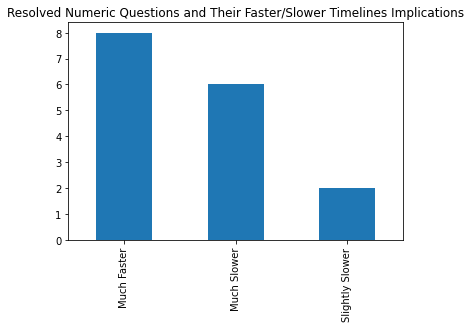

In [178]:
pd.Series(speeds).value_counts().drop("Not Relevant").plot(kind="bar", title="Resolved Numeric Questions and Their Faster/Slower Timelines Implications")

In [179]:
ll=[]
for i in dateqs:
    ll.append([i, snapshots[i]["t"],snapshots[i]['q1'],snapshots[i]["median"],snapshots[i]["q3"],snapshots[i]["Resolution"]])

In [180]:
datesframe=pd.DataFrame(ll, columns=["q","t","q1","q2","q3","Res"])
datesframe.index=datesframe["q"]
datesframe.head()

,q,t,q1,q2,q3,Res
q,,,,,,
2864,2864,1.562280e+09,0.04106,0.09611,0.18651,0.004059
2890,2890,1.576082e+09,0.34286,0.52668,0.78761,NaN
2840,2840,1.576082e+09,0.45628,0.63106,0.93522,NaN
2835,2835,1.610748e+09,-0.00100,0.00630,0.09287,NaN
2844,2844,1.610748e+09,0.03578,0.06741,0.14177,NaN


In [181]:
for q in dateqs:
    print(qs[q]['possibilities']["scale"]["max"],)

2030-05-06
2025-01-01
2025-01-01
2050-01-01
2029-12-29
2029-12-27
2060-01-01
2199-12-25
2110-01-04
2025-12-31
2039-12-29
2039-12-31
2026-03-28
2030-01-01
2031-08-29
2045-01-01
2039-12-31
2081-06-20
2041-01-01
2100-01-01
2099-12-30
2099-12-30
2022-06-01
2034-12-30
2030-12-29
2030-08-04
2034-12-26
2034-12-26
2034-12-23
2023-11-30
2119-12-29
2030-01-01
2024-07-21
2025-12-29
2099-12-23
2035-11-10
2030-01-01
2022-04-09
2099-12-25
2100-01-02
2029-12-29


In [182]:
datesframe["max"]=datesframe["q"].apply(lambda x: qs[x]['possibilities']["scale"]["max"])
datesframe["min"]=datesframe["q"].apply(lambda x: qs[x]['possibilities']["scale"]["min"])

In [184]:
datesframe["q1Time"]=datesframe[["q1","min", "max"]].apply(lambda x: gettimeinrange(*x), axis=1)

In [185]:
datesframe["q2Time"]=datesframe[["q2","min", "max"]].apply(lambda x: gettimeinrange(*x), axis=1)

In [186]:
datesframe["q3Time"]=datesframe[["q3","min", "max"]].apply(lambda x: gettimeinrange(*x), axis=1)

In [187]:
datesframe[datesframe.q1Time<datetime.today()]

,q,t,q1,q2,q3,Res,max,min,q1Time,q2Time,q3Time
q,,,,,,,,,,,
2864,2864,1.562280e+09,0.04106,0.09611,0.18651,0.004059,2030-05-06,2020-01-01,2020-06-04 02:59:32.352000000,2020-12-29 02:29:09.312,2021-12-05 15:14:04.992
2890,2890,1.576082e+09,0.34286,0.52668,0.78761,NaN,2025-01-01,2018-12-12,2021-01-08 09:45:06.048000000,2022-02-19 00:23:16.224,2023-09-19 04:38:22.848
2835,2835,1.610748e+09,-0.00100,0.00630,0.09287,NaN,2050-01-01,2020-01-01,2019-12-21 01:00:28.800000000,2020-03-10 00:50:58.560,2022-10-14 16:04:01.344
2844,2844,1.610748e+09,0.03578,0.06741,0.14177,NaN,2029-12-29,2019-12-10,2020-04-19 09:13:11.424000000,2020-08-13 12:42:30.528,2021-05-13 13:54:23.616
503,503,1.512395e+09,0.11231,0.23421,0.42700,0.048738,2039-12-29,2017-08-31,2020-03-03 21:18:47.520000000,2022-11-22 23:34:52.320,2027-03-14 04:26:24.000
3056,3056,1.595888e+09,0.14827,0.27382,0.49189,NaN,2031-08-29,2019-08-29,2021-06-08 20:49:04.224000008,2022-12-11 03:40:24.384,2025-07-23 22:53:34.368
1040,1040,1.538105e+09,0.17421,0.28329,0.48675,0.214494,2022-06-01,2018-08-01,2019-04-01 21:27:21.600000000,2019-09-01 14:32:38.400,2020-06-12 10:48:00.000
3272,3272,1.624810e+09,0.38169,0.50673,0.68572,NaN,2023-11-30,2019-10-31,2021-05-22 02:23:41.856000000,2021-11-24 12:49:34.752,2022-08-18 09:48:16.128
4869,4869,1.599876e+09,0.07267,0.10956,0.17983,0.110926,2024-07-21,2020-07-21,2020-11-04 04:06:03.168000000,2020-12-28 01:36:42.624,2021-04-09 17:33:32.832


In [188]:
datesframe[datesframe.q2Time<datetime.today()]

,q,t,q1,q2,q3,Res,max,min,q1Time,q2Time,q3Time
q,,,,,,,,,,,
2864,2864,1.562280e+09,0.04106,0.09611,0.18651,0.004059,2030-05-06,2020-01-01,2020-06-04 02:59:32.352,2020-12-29 02:29:09.312,2021-12-05 15:14:04.992
2835,2835,1.610748e+09,-0.00100,0.00630,0.09287,NaN,2050-01-01,2020-01-01,2019-12-21 01:00:28.800,2020-03-10 00:50:58.560,2022-10-14 16:04:01.344
2844,2844,1.610748e+09,0.03578,0.06741,0.14177,NaN,2029-12-29,2019-12-10,2020-04-19 09:13:11.424,2020-08-13 12:42:30.528,2021-05-13 13:54:23.616
1040,1040,1.538105e+09,0.17421,0.28329,0.48675,0.214494,2022-06-01,2018-08-01,2019-04-01 21:27:21.600,2019-09-01 14:32:38.400,2020-06-12 10:48:00.000
4869,4869,1.599876e+09,0.07267,0.10956,0.17983,0.110926,2024-07-21,2020-07-21,2020-11-04 04:06:03.168,2020-12-28 01:36:42.624,2021-04-09 17:33:32.832
776,776,1.541018e+09,0.11630,0.19206,0.30836,NaN,2025-12-29,2018-04-06,2019-02-28 10:20:55.680,2019-09-30 09:03:30.816,2020-08-23 19:24:26.496
4043,4043,1.600085e+09,0.33022,0.45095,0.60785,NaN,2022-04-09,2020-04-09,2020-12-06 01:27:15.840,2021-03-04 04:38:38.400,2021-06-26 17:31:55.200


In [189]:
datesframe[datesframe.q3Time<datetime.today()]

,q,t,q1,q2,q3,Res,max,min,q1Time,q2Time,q3Time
q,,,,,,,,,,,
2844,2844,1.610748e+09,0.03578,0.06741,0.14177,NaN,2029-12-29,2019-12-10,2020-04-19 09:13:11.424,2020-08-13 12:42:30.528,2021-05-13 13:54:23.616
1040,1040,1.538105e+09,0.17421,0.28329,0.48675,0.214494,2022-06-01,2018-08-01,2019-04-01 21:27:21.600,2019-09-01 14:32:38.400,2020-06-12 10:48:00.000
4869,4869,1.599876e+09,0.07267,0.10956,0.17983,0.110926,2024-07-21,2020-07-21,2020-11-04 04:06:03.168,2020-12-28 01:36:42.624,2021-04-09 17:33:32.832
776,776,1.541018e+09,0.11630,0.19206,0.30836,NaN,2025-12-29,2018-04-06,2019-02-28 10:20:55.680,2019-09-30 09:03:30.816,2020-08-23 19:24:26.496
4043,4043,1.600085e+09,0.33022,0.45095,0.60785,NaN,2022-04-09,2020-04-09,2020-12-06 01:27:15.840,2021-03-04 04:38:38.400,2021-06-26 17:31:55.200


In [190]:
datesframe.shape

(41, 11)

In [191]:
datesframe[datesframe.Res>=0]

,q,t,q1,q2,q3,Res,max,min,q1Time,q2Time,q3Time
q,,,,,,,,,,,
2864,2864,1.562280e+09,0.04106,0.09611,0.18651,0.004059,2030-05-06,2020-01-01,2020-06-04 02:59:32.352,2020-12-29 02:29:09.312,2021-12-05 15:14:04.992000000
3040,3040,1.570141e+09,0.18927,0.38797,0.57813,0.004152,2060-01-01,2020-01-01,2027-07-28 05:37:58.080,2035-07-09 05:48:02.880,2043-02-15 11:30:11.520000000
503,503,1.512395e+09,0.11231,0.23421,0.42700,0.048738,2039-12-29,2017-08-31,2020-03-03 21:18:47.520,2022-11-22 23:34:52.320,2027-03-14 04:26:24.000000000
1040,1040,1.538105e+09,0.17421,0.28329,0.48675,0.214494,2022-06-01,2018-08-01,2019-04-01 21:27:21.600,2019-09-01 14:32:38.400,2020-06-12 10:48:00.000000000
4869,4869,1.599876e+09,0.07267,0.10956,0.17983,0.110926,2024-07-21,2020-07-21,2020-11-04 04:06:03.168,2020-12-28 01:36:42.624,2021-04-09 17:33:32.832000000
3770,3770,1.592971e+09,0.03887,0.07460,0.13309,0.014384,2099-12-25,2020-02-21,2023-03-30 12:38:47.616,2026-02-04 11:38:41.280,2030-10-07 04:05:38.112000064
2848,2848,1.552214e+09,0.20299,0.41101,0.63839,0.002814,2029-12-29,2019-12-10,2021-12-24 09:06:09.792,2024-01-27 05:29:21.408,2026-05-11 04:02:02.112000000


## Process binary questions by flipping the sign of the ones we want to flip, this was taken from google doc

In [192]:
binmults={2829:1,2912:1,2982:1,2851:1,2891:1,2917:1,2875:1,2907:1,2919:1,2976:1,2859:1,2900:1,2908:1,2852:1,13:1,1335:1,345:1,45:1,903:1,9:1,2567:1,106:1,1019:1,170:-1,204:1,3762:1,344:1,5512:1,2535:1,207:1,470:-1,206:1,112:1,46:1,302:1,2871:1,3083:1,2837:1,2839:-1,2882:1,2847:1}

In [193]:
len(binmults)

41

In [194]:

for i in bincodes:
    try:
        if binmults[i]==-1:
            a=snapshots[i]["q1"]
            b=snapshots[i]["q3"]
            snapshots[i]["Resolution"]=1-snapshots[i]["Resolution"]
            snapshots[i]["median"]=1-snapshots[i]["median"]
            snapshots[i]["q1"]=1-b
            snapshots[i]["q3"]=1-a
    except:
        pass

In [195]:
lb=[]
for q in binmults.keys():
    if snapshots[q]["Resolution"] in [0.0,1.0]:
        lb.append([q,snapshots[q]["t"],snapshots[q]["q1"],snapshots[q]["median"],snapshots[q]["q3"],snapshots[q]["Resolution"]])
        
        
binframe=pd.DataFrame(lb, columns=["q","t","q1","q2","q3","Res"])

In [197]:
len(bincodes)

115

## Get quartiles of "how many questions were expected to resolve?"

In [198]:
np.sum(binframe.q1)

13.659999999999998

In [199]:
np.sum(binframe.q2)

17.48

In [200]:
np.sum(binframe.q3)

21.16

In [201]:
np.sum(binframe.Res)

11.0

In [202]:
binframe.shape

(41, 6)

In [204]:
binframe.head()

,q,t,q1,q2,q3,Res
0,2829,1.555083e+09,0.33,0.50,0.50,1.0
1,2912,1.573206e+09,0.39,0.48,0.60,1.0
2,2982,1.570854e+09,0.58,0.65,0.70,0.0
3,2851,1.561932e+09,0.15,0.20,0.25,0.0
4,2891,1.567235e+09,0.22,0.28,0.35,0.0


## Get Brier scores and expected Brier scores

In [205]:
binframe["EBrier"]=binframe["q2"].apply(lambda x: EBrier(x))

In [206]:
binframe["Brier"]=(binframe["Res"]-binframe["q2"])*(binframe["Res"]-binframe["q2"])

In [279]:
binframe.mean()

q           1.906073e+03
t           1.527860e+09
q1          3.331707e-01
q2          4.263415e-01
q3          5.160976e-01
Res         2.682927e-01
EBrier      2.031951e-01
Brier       2.026585e-01
OutcomeP    5.941463e-01
dtype: float64

## get overconfidence scores

In [208]:
binframe["OutcomeP"]=binframe[["q2", "Res"]].apply(lambda x:  pofr(*x), axis=1)

In [209]:
overconfidence(binframe.OutcomeP)

-0.005732152162584619

In [210]:
numcodes

dict_keys([2884, 2570, 3028, 2977, 2893, 2843, 2862, 2866, 2878, 2918, 2909, 2902, 5871, 6439, 5900, 1069, 438])

In [216]:
q1ps=[]
for i in binmults.keys():
    q1ps.append(snapshots[i]["q1"])

In [217]:
len(q1ps)

41

In [220]:
q2ps=[]
for i in binmults.keys():
    q2ps.append(snapshots[i]["median"])

In [223]:
q3ps=[]
for i in binmults.keys():
    q3ps.append(snapshots[i]["q3"])

<AxesSubplot:title={'center':'P(k results|these questions) using 25th percentile probabilities'}, xlabel='k', ylabel='P'>

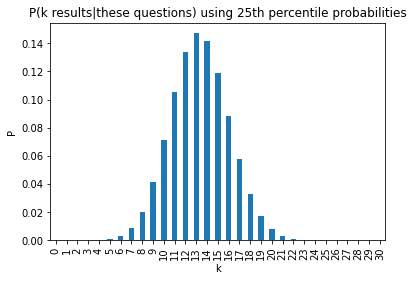

In [230]:
ps=[]
for i in range(31):
    ps.append((poissonbinomial(i,q1ps).real))
pd.Series(ps).plot(kind="bar", title="P(k results|these questions) using 25th percentile probabilities", xlabel="k", ylabel="P")

In [232]:
np.sum(ps[:12])

0.25049967520100697

<AxesSubplot:title={'center':'P(k results|these questions) using median probabilities'}, xlabel='k', ylabel='P'>

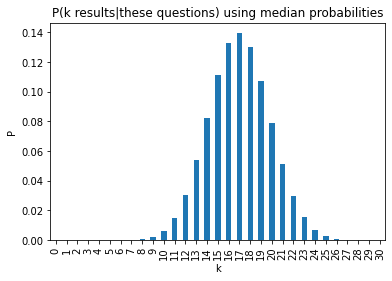

In [234]:
ps2=[]
for i in range(31):
    ps2.append((poissonbinomial(i,q2ps).real))
pd.Series(ps2).plot(kind="bar", title="P(k results|these questions) using median probabilities", xlabel="k", ylabel="P")

In [235]:
np.sum(ps2[:12])

0.02480438179479532

In [67]:
from datetime import datetime

## Get open duration for questions, then multiply by 0.75 as we took the prediction from 1/4 the way through

In [236]:
lengths=[]
for q in binmults.keys():
    lengths.append(datetime.fromtimestamp(qs[q]["community_prediction"]["history"][-1]["t"])-datetime.fromtimestamp(qs[q]["community_prediction"]["history"][1]["t"]))

In [237]:
np.mean(lengths)*.75

datetime.timedelta(days=79, seconds=72007, microseconds=462360)

In [239]:
np.percentile( lengths, 50)*.75

datetime.timedelta(days=77, seconds=68090, microseconds=214460)

In [240]:
np.max( lengths)*.75

datetime.timedelta(days=284, seconds=14647, microseconds=929759)

## Get number of predictions for the AI domain vs www domain questions

In [244]:
ai=[]
www=[]
for k in longaiqs:
    try:
        ai.append(snapshots[k]["nu"])
    except:
        pass
for k in allaiqs:
    try:
        www.append(snapshots[k]["nu"])
    except:
        pass

In [242]:
snapshots[k]

{'t': 1576082328.241388,
 'median': 0.52668,
 'q1': 0.34286,
 'q3': 0.78761,
 'ResolveTime': '2030-01-01T08:00:00Z',
 'np': 17,
 'nu': 12,
 'Resolution': None}

In [247]:
np.median(ai)

12.0

In [248]:
np.median(www)

39.0

In [250]:
len(qs)

259

In [251]:
len(allaiqs)

180

In [255]:
len(longlist)

73

In [258]:
c=list(set(allaiqs) & set(longaiqs))

In [259]:
len(c)

7

In [260]:
c

[2976, 2977, 2979, 2981, 2982, 3056, 3028]

In [265]:
d=list(set(longaiqs)&set(qs.keys()))

In [266]:
len(d)

97

In [267]:
e=list(set(allaiqs)&set(qs.keys()))

In [268]:
len(e)

169

In [269]:
97+169

266